<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜:
* 이름:

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts')
from lib import *

In [ ]:
'''lib.py
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
'''

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/kaggle.json
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [55]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
#! chmod 600 /content/drive/MyDrive/scripts/kaggle.json

In [57]:
! mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [58]:
! cp /content/drive/MyDrive/scripts/kaggle.json ~/.kaggle/kaggle.json

In [59]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **| EDA**

In [61]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


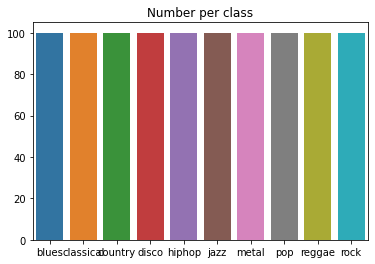

In [62]:
# 예측해야할 클래스
class_count = df['label'].value_counts()
plt.title('Number per class')
_=sns.barplot(x=class_count.index , y=class_count.values)

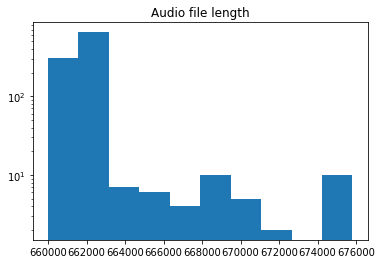

In [63]:
# 음성 파일의 길이
plt.title('Audio file length')
_=plt.hist(df['length'], log=True)

특성 개수 57


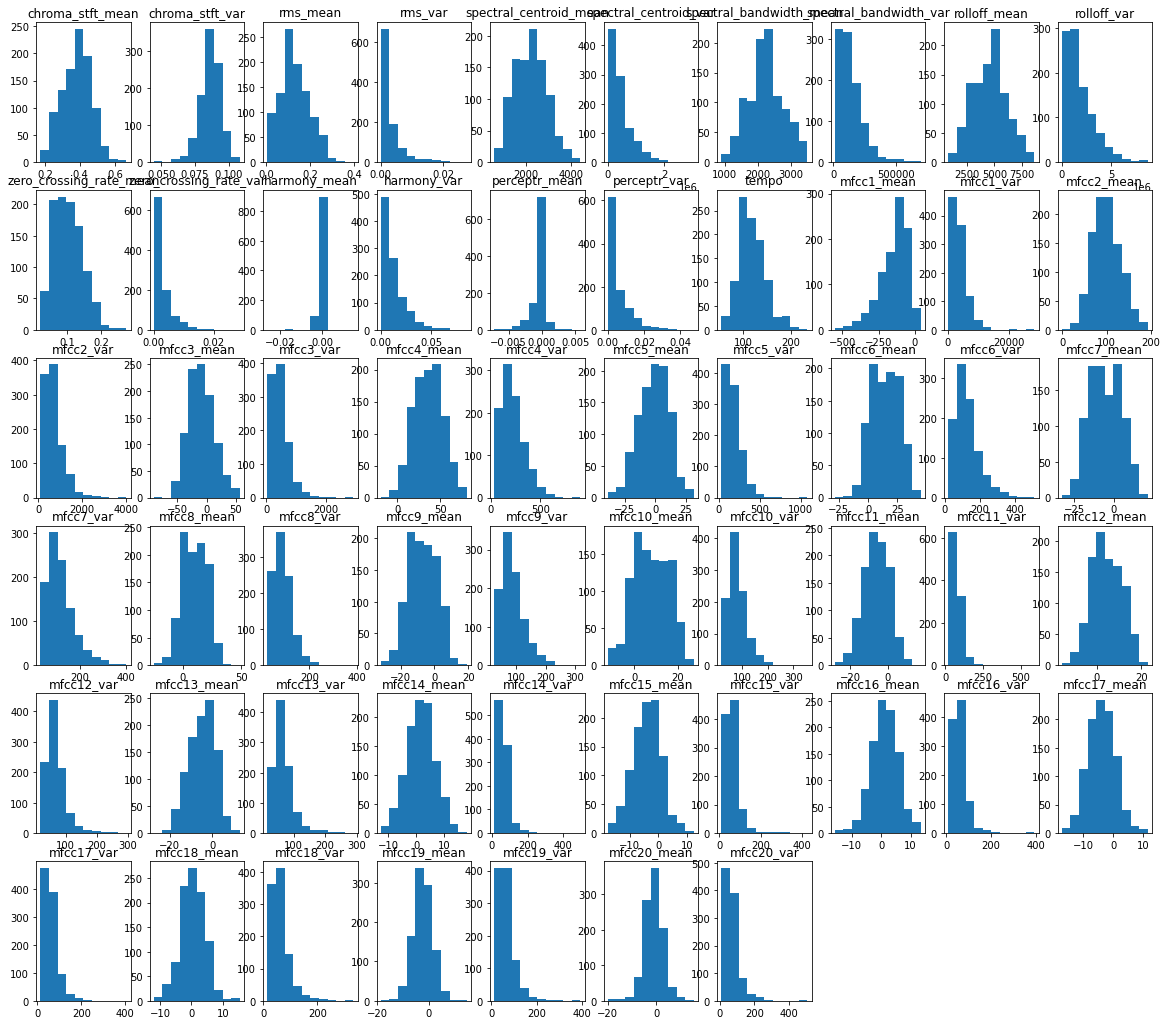

In [64]:
# 특성 분포 
print('특성 개수', len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]):
  plt.subplot(6,10, i+1)
  plt.title(col)
  plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


In [ ]:
import librosa

new_arr = np.zeros([1000, 8])
for i, (f_name, label) in enumerate(zip(df['filename'], df['label'])):
  if i%10==0: print(f'* {i}')
  if f_name =='jazz.00054.wav': continue
  dir_path =  f'/content/Data/genres_original/{label}'
  f_path = f'{dir_path}/{f_name}'
  # file path로부터 wav 데이터 읽기
  y, sr = librosa.load(f_path) #y: 데이터(1차원 배열)  sr: sampling rate
  # print(f_path, y.shape)
  # 읽어낸 데이에서 feautre를 추출
  chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
  spectral_flatness = librosa.feature.spectral_flatness(y=y)
  tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

  chroma_cens_mean = np.mean(chroma_cens)
  chroma_cens_var = np.var(chroma_cens)
  spectral_contrast_mean = np.mean(spectral_contrast)
  spectral_contrast_var = np.var(spectral_contrast)
  spectral_flatness_mean = np.mean(spectral_flatness)
  spectral_flatness_var = np.var(spectral_flatness)
  tonnetz_mean = np.mean(tonnetz)
  tonnetz_var = np.var(tonnetz)

  new_arr[i, 0]=chroma_cens_mean
  new_arr[i, 1]=chroma_cens_var
  new_arr[i, 2]=spectral_contrast_mean
  new_arr[i, 3]=spectral_contrast_var
  new_arr[i, 4]=spectral_flatness_mean
  new_arr[i, 5]=spectral_flatness_var
  new_arr[i, 6]=tonnetz_mean
  new_arr[i, 7]=tonnetz_var

new_arr.shape

In [ ]:
df.shape, new_arr.shape

((1000, 61), (1000, 8))

In [ ]:
df['chroma_cens_mean'] = new_arr[:, 0]
df['chroma_cens_var'] = new_arr[:, 1]
df['spectral_contrast_mean'] = new_arr[:, 2]
df['spectral_contrast_var'] = new_arr[:, 3]
df['spectral_flatness_mean'] = new_arr[:, 4]
df['spectral_flatness_var'] = new_arr[:, 5]
df['tonnetz_mean']= new_arr[:, 6]
df['tonnetz_var']= new_arr[:, 7]

In [ ]:
print(df.shape)
df.head()

(1000, 69)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,label,le_label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,blues,0,0.272036,0.009330,20.526699,76.741834,0.004498,0.000030,0.007162,0.004417
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,blues,0,0.260980,0.015223,20.676128,67.851520,0.002298,0.000024,0.029154,0.004762
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,blues,0,0.262627,0.014360,22.197517,76.130717,0.002631,0.000011,0.024264,0.010511
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,blues,0,0.226383,0.032084,21.426268,63.384626,0.000954,0.000003,0.026562,0.017854
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,blues,0,0.259550,0.015967,21.466338,62.986186,0.003238,0.000019,-0.020919,0.010125


In [ ]:
# 추가된 데이터 로 전처리 
  # 데이터 하나 빼기 (데이터 프레임에서 한줄만 제거하면 된다. (jazz0054))

# 추가된 데이터 머신러닝 돌리기
  # pycaret

# 추가된 데이터 딥러닝 돌리기

### **| 전처리**


In [ ]:
# label encoding ( blues, classical, ... ) - > (0, 1, ...)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,label,le_label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,blues,0,0.272036,0.009330,20.526699,76.741834,0.004498,0.000030,0.007162,0.004417
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,blues,0,0.260980,0.015223,20.676128,67.851520,0.002298,0.000024,0.029154,0.004762
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,blues,0,0.262627,0.014360,22.197517,76.130717,0.002631,0.000011,0.024264,0.010511
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,blues,0,0.226383,0.032084,21.426268,63.384626,0.000954,0.000003,0.026562,0.017854
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,blues,0,0.259550,0.015967,21.466338,62.986186,0.003238,0.000019,-0.020919,0.010125


In [ ]:
x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
y = df['le_label']
x.shape, y.shape

((1000, 65), (1000,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (900, 65) (900,)
test (100, 65) (100,)


In [ ]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((900, 65), (100, 65))

### **| 학습 - XGBoost**

In [ ]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc: 0.83


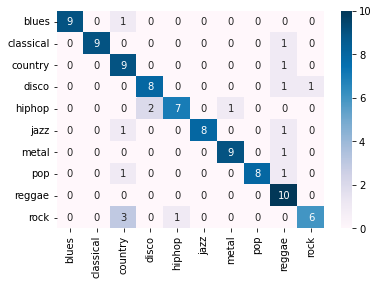

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test, proba=False):
  y_pred = model.predict(x_test)
  if proba: 
    y_pred = np.argmax(y_pred, axis=1)
  print('Test Acc:', accuracy_score(y_test, y_pred))
  #print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  _=sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels=le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)

### **| 학습 - DNN**

In [ ]:
# 딥러닝 (Dense layer)
def build_dnn():
  x = layers.Input(shape=(65,))
  y = layers.Dense(1024, activation='relu')(x)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(10, activation='softmax')(y)
  model = models.Model(x, y)
  return model

In [ ]:
dnn = build_dnn()
dnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 65)]              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              67584     
                                                                 
 dense_7 (Dense)             (None, 128)               131200    
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 200,074
Trainable params: 200,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
dnn.fit(x_train, y_train, epochs=15, batch_size=8)

Epoch 1/15
113/113 [==============================] - 1s 2ms/step - loss: 1.2948 - accuracy: 0.5378
Epoch 2/15
113/113 [==============================] - 0s 2ms/step - loss: 0.7282 - accuracy: 0.7444
Epoch 3/15
113/113 [==============================] - 0s 2ms/step - loss: 0.5280 - accuracy: 0.8333
Epoch 4/15
113/113 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.8778
Epoch 5/15
113/113 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.9167
Epoch 6/15
113/113 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.9278
Epoch 7/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9500
Epoch 8/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9600
Epoch 9/15
113/113 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.9778
Epoch 10/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9767

Test Acc: 0.73


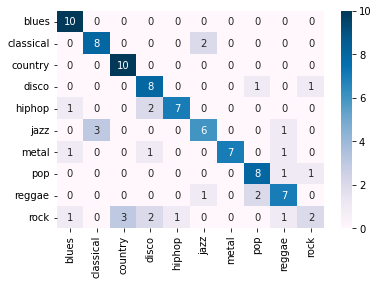

In [ ]:
show_result(dnn, x_test, y_test, proba=True)

## 딥러닝 접근 방법(Audio 원 데이터)
---

In [77]:
csv_path = '/content/Data/features_30_sec.csv'
data_dir = '/content/Data/genres_original'
class_dict = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9
}

def df_process(csv_path, data_dir, class_dict):
  df = pd.read_csv(csv_path)
  # 불량 데이터 삭제
  #np.where(df['filename']=='jazz.00054.wav')
  df = df.drop(index=[554])
  # 파일 경로 재설정
  '''
  blues.00000.wav' -> '/content/Data/genres_original/blues/blues.00000.wav'
  '''
  df['filepath'] = df.apply( lambda x:  f'{data_dir}/{x["label"]}/{x["filename"]}', axis=1 )
  # 라벨 인코딩 
  df['label'] = df['label'].map(class_dict)
  
  return list(df['filepath']), list(df['label'])

paths, labels = df_process(csv_path, data_dir, class_dict)
print(len(paths), paths[:2])
print(len(labels), labels[:2])

999 ['/content/Data/genres_original/blues/blues.00000.wav', '/content/Data/genres_original/blues/blues.00001.wav']
999 [0, 0]


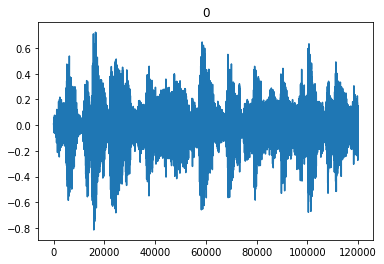

In [88]:
# 경로 -> wav 데이터 추출

def path2wav(path, label, mx_len=120000):
  # 파일 읽기
  f = tf.io.read_file(path)
  # 파일을 오디오 변환
  wav, sr = tf.audio.decode_wav(f, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  wav = wav[:mx_len]
  return wav, label

wav, label = path2wav(paths[0], labels[0])
plt.title(label)
plt.plot(wav)

from IPython import display
display.Audio(wav, rate=16000)

In [94]:
# 텐서플로우 텐서 슬라이스

def ds_generator(paths, labels, batch_size=10, train=True):
  ds = tf.data.Dataset.from_tensor_slices( (paths, labels) )
  ds = ds.map(path2wav)
  if train:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  return ds


from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, 
                                                                      test_size=0.1, 
                                                                      stratify=labels, 
                                                                      random_state=0)

print('train', len(train_paths), len(train_labels))
print('test', len(test_paths), len(test_labels))

train_ds = ds_generator(train_paths, train_labels)
test_ds = ds_generator(test_paths, test_labels, train=False)

train 899 899
test 100 100
